In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from torch.utils.data import Dataset, DataLoader

In [4]:
train_file = "train.csv"
test_file = "test.csv"
label_column = "class"

df = pd.read_csv(train_file)
df

,class,lx0,lx1,lx2,lx3,lx4,lx5,lx6,lx7,lx8,...,ry2038,ry2039,ry2040,ry2041,ry2042,ry2043,ry2044,ry2045,ry2046,ry2047
0,25,74,122,127,122,119,115,112,106,99,...,646,634,630,622,617,615,611,607,605,602
1,31,-14,-4,14,-3,11,0,6,6,1,...,383,392,383,386,389,381,388,384,385,387
2,12,-10,11,8,10,11,10,8,12,11,...,198,198,198,200,201,199,199,199,197,199
3,12,114,168,167,171,166,172,166,172,172,...,201,202,198,200,198,197,197,194,197,192
4,12,-13,11,11,10,12,17,16,20,21,...,-365,-368,-369,-369,-366,-372,-371,-371,-372,-374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647,12,30,65,64,64,61,68,62,63,66,...,118,122,119,119,117,117,118,114,119,117
648,21,80,119,120,118,110,106,106,105,104,...,-94,-89,-88,-85,-83,-84,-86,-88,-90,-88
649,33,28,76,70,68,76,63,78,64,75,...,79,77,79,77,76,82,78,82,77,86
650,12,-62,-58,-59,-57,-57,-57,-59,-55,-59,...,193,194,191,192,189,187,188,186,186,185


In [5]:
unique = list(df["class"].unique())
unique.sort()
unique

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37]

In [6]:
na_counts = df.isna().sum()
na_counts, na_counts.sum()

(class     0
 lx0       0
 lx1       0
 lx2       0
 lx3       0
          ..
 ry2043    0
 ry2044    0
 ry2045    0
 ry2046    0
 ry2047    0
 Length: 8193, dtype: int64,
 0)

In [7]:
empty_counts = (df == '').sum()
empty_counts, empty_counts.sum()

(class     0
 lx0       0
 lx1       0
 lx2       0
 lx3       0
          ..
 ry2043    0
 ry2044    0
 ry2045    0
 ry2046    0
 ry2047    0
 Length: 8193, dtype: int64,
 0)

In [8]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [9]:
class TabularDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.features[idx], dtype=torch.float32),
            torch.tensor(self.labels[idx], dtype=torch.long),
        )

In [10]:
## Preprocessing the data
def preprocess_data(file, label_column, test_size=0.2, random_state=42, top_k_features=None):
    df = pd.read_csv(file)

    ##Handle column names with unexpected characters
    df.columns = df.columns.str.strip().str.replace(r"[^\w\s]", "", regex=True)

    # Replace missing values
    df.replace("?", np.nan, inplace=True)
    df.fillna(df.mean(), inplace=True)

    # Extract labels and features
    labels = df[label_column].values
    features = df.drop(columns=[label_column]).values

    # Ensuring label range starts from 0
    unique_labels = sorted(np.unique(labels))
    label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
    labels = np.array([label_mapping[label] for label in labels])

    scaler = StandardScaler()
    features = scaler.fit_transform(features)

    ## Default is None
    if top_k_features:
        selector = SelectKBest(f_classif, k=top_k_features)
        features = selector.fit_transform(features, labels)

    ###train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=test_size, random_state=random_state
    )

    return X_train, y_train, X_test, y_test, len(unique_labels)

In [11]:
#Define the model
class TabularModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(TabularModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
        )

    def forward(self, x):
        return self.fc(x)


In [12]:
# Train the model with early stopping and checkpointing
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

In [13]:
# Evaluate the model
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
    accuracy = correct / len(test_loader.dataset)
    return total_loss / len(test_loader), accuracy

In [14]:
# Early stopping and model checkpointing
def early_stopping(model, val_loss, best_val_loss, patience_counter, patience, checkpoint_path="best_model.pth"):
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), checkpoint_path)
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping after {patience} epochs of no improvement.")
        return True, best_val_loss, patience_counter

    return False, best_val_loss, patience_counter

In [15]:

file = "train.csv"
label_column = "class"
test_size = 0.2
random_state = 42
batch_size = 64
learning_rate = 0.001
num_epochs = 100
patience = 40

In [16]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [17]:

# Preprocess data
X_train, y_train, X_test, y_test, num_classes = preprocess_data(
    file, label_column, test_size=test_size, random_state=random_state
)

In [18]:
# Create datasets and dataloaders
train_dataset = TabularDataset(X_train, y_train)
test_dataset = TabularDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [19]:
# Define model, loss, and optimizer
input_dim = X_train.shape[1]
model = TabularModel(input_dim, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [20]:

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [21]:
# Tracking variables for visualization and early stopping
train_losses, val_losses, accuracies = [], [], []
best_val_loss = float('inf')
patience_counter = 0

In [22]:
# Train and evaluate the model
for epoch in range(num_epochs):
    train_loss = train_model(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = evaluate_model(model, test_loader, criterion, device)

    # Early stopping check
    stop, best_val_loss, patience_counter = early_stopping(
        model, val_loss, best_val_loss, patience_counter, patience
    )
    if stop:
        break

    scheduler.step()

    # Store losses and accuracies for visualization
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    accuracies.append(val_accuracy)

    ## Print progress
    print(f"Epoch {epoch + 1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Val Accuracy = {val_accuracy:.4f}")


Epoch 1: Train Loss = 2.9624, Val Loss = 2.7308, Val Accuracy = 0.3664
Epoch 2: Train Loss = 1.8076, Val Loss = 2.0982, Val Accuracy = 0.5191
Epoch 3: Train Loss = 1.4630, Val Loss = 1.7343, Val Accuracy = 0.5878
Epoch 4: Train Loss = 1.1328, Val Loss = 1.6434, Val Accuracy = 0.5573
Epoch 5: Train Loss = 0.9275, Val Loss = 1.4955, Val Accuracy = 0.6183
Epoch 6: Train Loss = 0.6683, Val Loss = 1.2594, Val Accuracy = 0.6183
Epoch 7: Train Loss = 0.5569, Val Loss = 1.3627, Val Accuracy = 0.6336
Epoch 8: Train Loss = 0.4341, Val Loss = 1.4560, Val Accuracy = 0.6794
Epoch 9: Train Loss = 0.6037, Val Loss = 1.5604, Val Accuracy = 0.6870
Epoch 10: Train Loss = 0.4327, Val Loss = 1.2856, Val Accuracy = 0.7176
Epoch 11: Train Loss = 0.4451, Val Loss = 1.1674, Val Accuracy = 0.6565
Epoch 12: Train Loss = 0.3456, Val Loss = 1.2655, Val Accuracy = 0.7023
Epoch 13: Train Loss = 0.3308, Val Loss = 1.0785, Val Accuracy = 0.7252
Epoch 14: Train Loss = 0.2698, Val Loss = 1.7203, Val Accuracy = 0.6870
E

In [23]:
# Load the best model
model.load_state_dict(torch.load("best_model.pth"))

<ipython-input-23-e464e5835b6e>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


<All keys matched successfully>

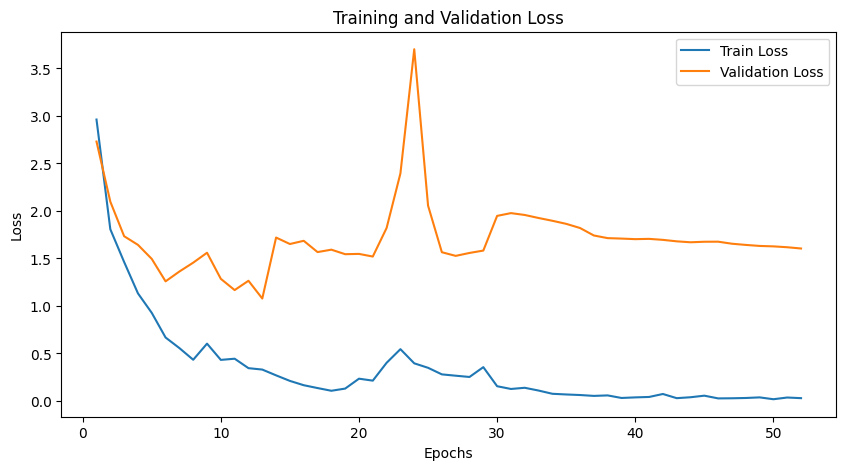

In [24]:
# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

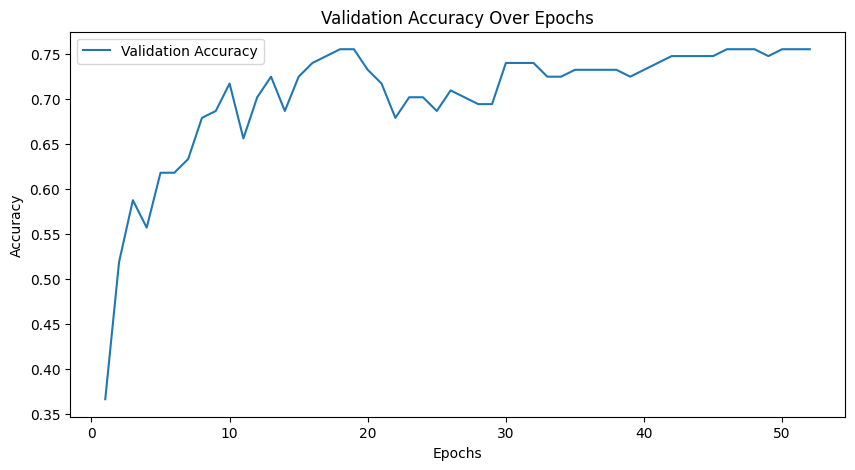

In [25]:
# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(accuracies) + 1), accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()